# Fine Structure Model
In the notebook a single spectrum of SrTiO$_3$ will be analyzed with different methods. 
1. Conventional power-law: Estimation of the background by fitting a power-law to the pre edge region.
2. Model-based approach: Define a model with fine structure, all the steps are shown on how to get the results
3. Workflow with Fine Structure: A ElementalQuantification class will be used to do easy quantification within some workflow
4. Workflow excluded Fine Structure: The same workflow will be utilized to do the fit when the fine structure is excluded.


In [1]:
%matplotlib qt5

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyEELSMODEL.api as em
from pyEELSMODEL.components.linear_background import LinearBG
from pyEELSMODEL.components.CLedge.zezhong_coreloss_edgecombined import ZezhongCoreLossEdgeCombined
from pyEELSMODEL.components.gdoslin import GDOSLin
from pyEELSMODEL.components.MScatter.mscatterfft import MscatterFFT

In [3]:
cdir = os.getcwd()
print('Current directory is: ' + cdir)

Current directory is: C:\Users\DJannis\PycharmProjects\project\pyEELSMODEL\examples


In [8]:
filename = os.path.join(cdir, 'data', 'hl.msa')
filenamell = os.path.join(cdir, 'data', 'll.msa')

In [5]:
#The experimental parameters 
alpha = 0.9e-3 #convergence angle [rad]
beta = 2.675e-3 #collection angle [rad]
E0 = 300e3 #acceleration voltage [V]

In [6]:
# The edges in the spectrum
elements = ['Ti', 'O']
edges = ['L', 'K']

## Loading the datasets

In [9]:
s0 = em.Spectrum.load(filename)
ll = em.Spectrum.load(filenamell)

this will change the size and contents of the current spectrum
this will change the size and contents of the current spectrum


In [10]:
#the core loss spectrum
s0.plot()

In [11]:
#the low loss spectrum
ll.plot()

## Conventional power-law subtraction
It is shown how the conventional background subtraction will be performed on a single spectrum. A background window (*windows*) should be selected and integration range (*ranges*) should be chosen.

In [12]:
#A list of integration windows
windows = [[454,500],[530,590]]
#The signal ranges over which needs to be fitted
ranges = [(380,450),(512,527)]


In [13]:
#The background fitting procedure
conv_abundance = np.zeros(len(windows)) #the integrated intensities will be saved in this array
for ii in range(len(windows)):
    back = em.BackgroundRemoval(s0, signal_range=ranges[ii]) #background removal object
    s0_rem = back.calculate() #calculates the background subtracted signal
    conv_abundance[ii] = back.quantify_from_edge(windows[ii], elements[ii], edges[ii], E0, alpha, beta, ll=ll)
    fig = back.show_fit_result(integration_range=windows[ii]) #small function which shows the fitted result
    fig.axes[0].set_title(elements[ii])


## Model based fitting
A model based fitting approach is used to quantify the core-loss spectrum. 

#### Model
The model  needs to be defined and consist out of four components.
1. Background: Linear background model
2. Titanium L edge
3. Oxygen K edge
4. Low-loss to take multiple scattering into account

In [14]:
#The background model, in this case it is linear
specshape = s0.get_spectrumshape()
BG = LinearBG(specshape, rlist=np.linspace(1,5,4))

In [15]:
#The components of the edges
#Rather slow due to cross section computation
comp_elements = []
for elem, edge in zip(elements, edges):
    comp = ZezhongCoreLossEdgeCombined(specshape, 1, E0, alpha, beta, elem, edge)
    comp_elements.append(comp)

In [16]:
#Add fine structure on the edges
comp_fine = []
for comp in comp_elements:
    comp_fine.append(GDOSLin.gdoslin_from_edge(specshape, comp, pre_e=5, ewidth=50, degree=30))
#pre_e: is how much energy before the edge onset, the linear interpolation can be performed
#ewidth: the width of the interpolation region
#degree: The number of points used in the interpolated region

In [17]:
#The low loss spectrum which is the convolutor
ll_comp = MscatterFFT(specshape, ll)

In [18]:
#the list containing all the components
component_list = [BG]+comp_elements+comp_fine+[ll_comp]


In [19]:
#Defining the model we are going to use to fit the spectrum
mod = em.Model(specshape, components=component_list) #The model object

### Fitter
A linear fitter is chosen since the model is enitirely linear. 

In [20]:
#Defining the fitter used which in this case is the linear fitter
fit = em.LinearFitter(s0, mod, method='ols') #The fitter object 

cannot use analytical gradients since a convolutor is inside model


In [21]:
#Performing the fit
fit.perform_fit()


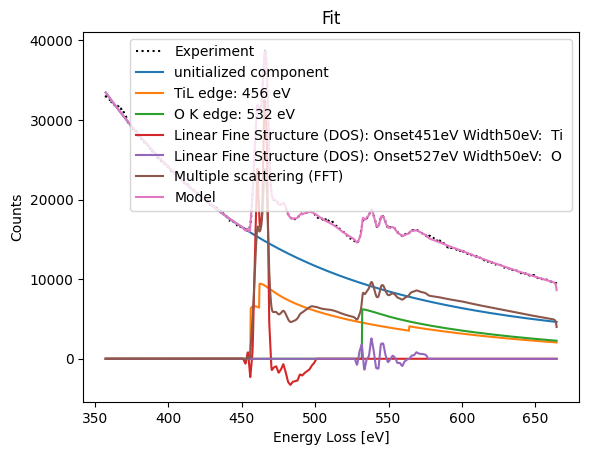

In [22]:
fit.plot()

## Elemental Quantification: Fine structure
The next part does the elemental quantification in a workflow which is similar to the previous part but here it is all put into one class as some kind of workflow. 

In [23]:
settings=(E0, alpha, beta)
quant = em.ElementalQuantification(s0, elements, edges, settings, ll=ll)
quant.n_bgterms = 4
quant.use_fine=True
quant.fine_intervals = [50,50]
quant.linear_fitter_method = 'ols'
quant.do_procedure()

zlp alignment is only performed on multispectra


cannot use analytical gradients since a convolutor is inside model


1.1999995999999982
41
41


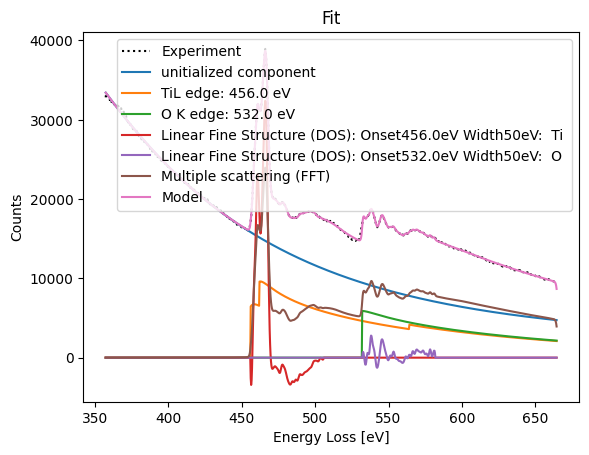

In [24]:
quant.fitter.plot()

## Elemental Quantification: Excluded fine structure
A common method is processing EELS data is by excluding the fine structure region. The next part shows how one can do this with the ElementalQuantification class. The first step is to copy the spectrum since we are going to exclude some parts of the data and this exclude is a attribute of the Spectrum class. 

In [25]:
se = s0.copy()

In [26]:
se.reset_exclude_region()
se.set_exclude_region_energy(450,500)
se.set_exclude_region_energy(528,590)
se.show_excluded_region()

In [27]:
settings=(E0, alpha, beta)
quantex = em.ElementalQuantification(se, elements, edges, settings, ll=ll)
quantex.n_bgterms = 4
quantex.linear_fitter_method = 'ols'
quantex.do_procedure()

zlp alignment is only performed on multispectra


cannot use analytical gradients since a convolutor is inside model


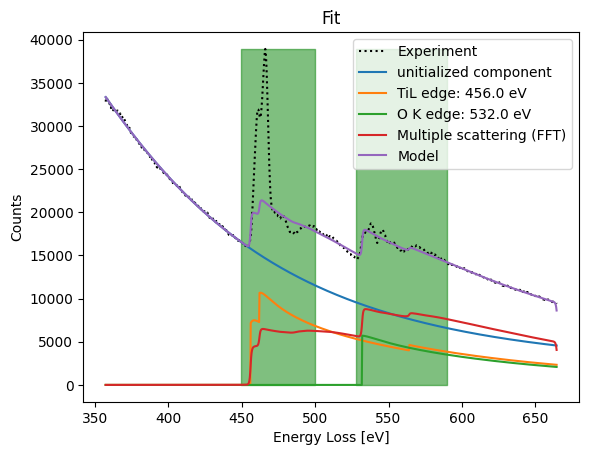

In [28]:
quantex.fitter.plot()

# Quantification of Ti/O
Here it shown how to get the elemental quanticiations from the fitted spectra. It is seen how different methods already introduce different values for the quantification. Hence, be carefull with trying to estimate absolute elemental abundances with EELS. 

In [29]:
conv_TiO = conv_abundance[0]/conv_abundance[1]
model_TiO = comp_elements[0].parameters[0].getvalue()/comp_elements[1].parameters[0].getvalue()
quant_TiO = quant.element_components[0].parameters[0].getvalue()/quant.element_components[1].parameters[0].getvalue()
quantex_TiO = quantex.element_components[0].parameters[0].getvalue()/quantex.element_components[1].parameters[0].getvalue()

In [30]:
print('Titanium over oxygen ratio is expected to be 0.333')
print('Conventional Power-law: ' + str(conv_TiO))
print('Model-based: ' + str(model_TiO))
print('Model-based using ElementalQuantification: ' + str(quant_TiO))
print('Model-based using ElementalQuantification without fine structure: ' + str(quantex_TiO))

Titanium over oxygen ratio is expected to be 0.333
Conventional Power-law: 0.27550230929967107
Model-based: 0.26271477420649775
Model-based using ElementalQuantification: 0.28249838765692953
Model-based using ElementalQuantification without fine structure: 0.3246121302891768
